In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fft as fft
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import levy
from iminuit import Minuit
from scipy.optimize import curve_fit

Initial conditions

In [2]:
'''
Good conditions - good ttcf and g2:

dim = 750 #[nm]
N = 35
radius = 10 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0

#Detector parameters
s_dim = 2000 #[um]
dev = 50
roi_params = [100,300]

temp = 50

p_amount = int(N * 0.1) #How many particles to move
step_size = [5,10] #Size of step
''';

In [3]:
#sample parameters

dim = 750 #[nm]
N = 50
radius = 10 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0

#Detector parameters
s_dim = 2000 #[um]
dev = 50
#roi_params = [int(dim / 10), int(dim / 3)]
roi_params = [80,100]

temp = [30,50]
p_amount = int(N * 0.1) #How many particles to move
step_size = [2,5] #Size of step

n_frames = 100 #Amoun of images to generate

In [4]:
conc = (np.pi * radius ** 2 * N) / (dim ** 2)
conc

0.027925268031909273

Initial sample

In [5]:
def p_locs(N, dev, min_distance): #Create sample with normal distribution   
    positions = []
    center = [(bounds[0] + bounds[1]) / 2, (bounds[0] + bounds[1]) / 2]  # Center of the bounds

    while len(positions) < N:
        # Generate new position with a normal distribution centered at the center
        new_pos = np.random.normal(loc = center, scale = dev, size = (2,))
        
        # Ensure new position is within bounds
        if (bounds[0] + radius <= new_pos[0] <= bounds[1] - radius) and (bounds[0] + radius <=
                                                                         new_pos[1] <= bounds[1] - radius):
            # Check distances from existing particles
            if len(positions) > 0:
                distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
                if np.all(distances >= min_distance):
                    positions.append(new_pos)
            else:
                positions.append(new_pos)

    return np.array(positions)

In [6]:
def p_locs1(N, s_dim, min_distance): #Creates an array of particle locations (original)

    #Find open locations for each particle
    
    positions = []
    while len(positions) < N:
        new_pos = np.random.uniform(bounds[0] + radius, bounds[1] - radius, size=(2,))
        
        # Check distances from existing particles
        if len(positions) > 0:
            distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
            if np.all(distances >= min_distance):
                positions.append(new_pos)
        else:
            positions.append(new_pos)

    return np.array(positions)


##################################################

def sample(locs, radius): #Places the particle's location in a matrix - creating the sample matrix
    sample = np.zeros((dim, dim))
    for i in range(len(locs)):
        xx, yy = np.meshgrid(range(dim), range(dim))
        dist_squared = (xx - locs[:,0][i]) ** 2 + (yy - locs[:,1][i]) ** 2
        sample[dist_squared <= radius ** 2] = 1
    
    return sample

In [7]:
#Generate particle coordinates
particle_loc = p_locs(N, dev, 2 * radius)

#Generate sample matrix
init_sample = sample(particle_loc, radius)

Text(0.5, 1.0, 'Initial positions in the sample')

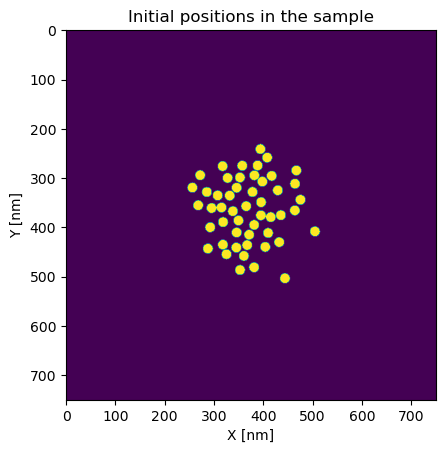

In [8]:
plt.imshow(init_sample) #Image of sample matrix
plt.xlabel('X [nm]')
plt.ylabel('Y [nm]')
plt.title('Initial positions in the sample')
#plt.savefig('pics/init_pos_brown.png', dpi = 300)

Moving particles

In [9]:
np.sqrt(np.random.normal(temp, scale = (step_size[1] - step_size[0])))

array([5.3655665, 6.8675345])

In [10]:
def brown_motion(ip, step, diff, bounds, p_amount):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  
    
    # Moving x amount of particles
    parts = np.random.randint(0, len(ip), p_amount)  # which particles to move

    for i in range(len(parts)):
        step_size = np.random.randint(step[0], step[1], 1)  # Step size of particle
        p_step = np.random.normal(scale = np.sqrt(2 * diff * step_size), size=2)  # Change coordinate
        new_positions[parts[i]] = ip[parts[i]] + p_step

       #  #Boundary conditions - periodic
       # if new_positions[parts[i]][0] + radius > bounds[1]:
       #     new_positions[parts[i]][0] = bounds[0] + radius
       # elif new_positions[parts[i]][0] - radius < bounds[0]:
       #     new_positions[parts[i]][0] = bounds[1] - radius
       # if new_positions[parts[i]][1] + radius > bounds[1]:
       #     new_positions[parts[i]][1] = bounds[0] + radius
       # elif new_positions[parts[i]][1] - radius < bounds[0]:
       #     new_positions[parts[i]][1] = bounds[1] - radius
       # 
        
        #Hard boundaries
        if new_positions[parts[i]][0] + radius > bounds[1]:
            new_positions[parts[i]][0] = bounds[1] - radius
        elif new_positions[parts[i]][0] - radius < bounds[0]:
            new_positions[parts[i]][0] = bounds[0] + radius
        if new_positions[parts[i]][1] + radius > bounds[1]:
            new_positions[parts[i]][1] = bounds[1] - radius
        elif new_positions[parts[i]][1] + radius < bounds[0]:
            new_positions[parts[i]][1] = bounds[0] + radius
            
    # Collision avoidance, if their trajectories collide - they go back to their old position
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                new_positions[i] = old_positions[i]
                new_positions[j] = old_positions[j]

    return new_positions, old_positions


In [11]:
def brown_motion_temp(ip, step, diff, bounds, p_amount, temperature, radius):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  
    
    # Moving x amount of particles
    parts = np.random.randint(0, len(ip), p_amount)  # which particles to move

    for i in range(len(parts)):
        temp_factor = np.sqrt(abs(np.random.normal(temperature, scale = 10)))
        
        step_size = np.random.randint(int(step[0] + (0.5 * temp_factor)), 
                                      int(step[1] + (0.5 * temp_factor)) , 1)  # Step size of particle
        
        p_step = np.random.normal(scale = np.sqrt(2 * (diff) * step_size), size=2)  # Change coordinate
        new_positions[parts[i]] = ip[parts[i]] + p_step
        
        #print(step_size)

        # #Boundary conditions - periodic
        #if new_positions[parts[i]][0] + radius > bounds[1]:
        #    new_positions[parts[i]][0] = bounds[0] + radius
        #elif new_positions[parts[i]][0] - radius < bounds[0]:
        #    new_positions[parts[i]][0] = bounds[1] - radius
        #if new_positions[parts[i]][1] + radius > bounds[1]:
        #    new_positions[parts[i]][1] = bounds[0] + radius
        #elif new_positions[parts[i]][1] - radius < bounds[0]:
        #    new_positions[parts[i]][1] = bounds[1] - radius
        
        
        if new_positions[parts[i]][0] + radius > bounds[1]:
            new_positions[parts[i]][0] = bounds[1] - radius
        elif new_positions[parts[i]][0] - radius < bounds[0]:
            new_positions[parts[i]][0] = bounds[0] + radius
        if new_positions[parts[i]][1] + radius > bounds[1]:
            new_positions[parts[i]][1] = bounds[1] - radius
        elif new_positions[parts[i]][1] + radius < bounds[0]:
            new_positions[parts[i]][1] = bounds[0] + radius
            
    # Collision avoidance, if their trajectories collide - they go back to their old position
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                new_positions[i] = old_positions[i]
                new_positions[j] = old_positions[j]

    return new_positions, old_positions


In [12]:
def levy_motion(ip, bounds, p_amount, step_scale):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  # Initialize new_positions as a copy of ip
    
    # Moving x amount of particles
    parts = np.random.choice(len(ip), p_amount, replace=False)  # which particles to move

    # Lévy flight steps
    step_sizes = levy.rvs(size=p_amount) * step_scale # Step sizes from Lévy distribution
    angles = np.random.uniform(0, 2 * np.pi, p_amount)  # Random angles for direction
    
    p_steps = np.zeros((p_amount, 2))
    p_steps[:, 0] = step_sizes * np.cos(angles)
    p_steps[:, 1] = step_sizes * np.sin(angles)
    
    new_positions[parts] += p_steps

    # Boundary conditions - periodic
    new_positions[parts] = (new_positions[parts] + bounds[1] - bounds[0]) % (bounds[1] - bounds[0]) + bounds[0]

    # Collision avoidance
    dist_matrix = np.linalg.norm(new_positions[:, None, :] - new_positions[None, :, :], axis=-1)
    collision_indices = np.where((dist_matrix < 2 * radius) & (dist_matrix != 0))
    for i, j in zip(*collision_indices):
        if i < j:  # to prevent double handling
            new_positions[i] = old_positions[i]
            new_positions[j] = old_positions[j]

    return new_positions, old_positions

In [13]:
new_pos, old_pos = brown_motion(particle_loc, step_size, diff, bounds, p_amount)
#levy_npos, levy_opos = levy_motion(particle_loc, bounds, p_amount, 0.1)

In [14]:
#new_pos - particle_loc #check to see if particles moved
#levy_npos - levy_opos

In [15]:
brown_samp = sample(new_pos, radius) #generate image of altered sample

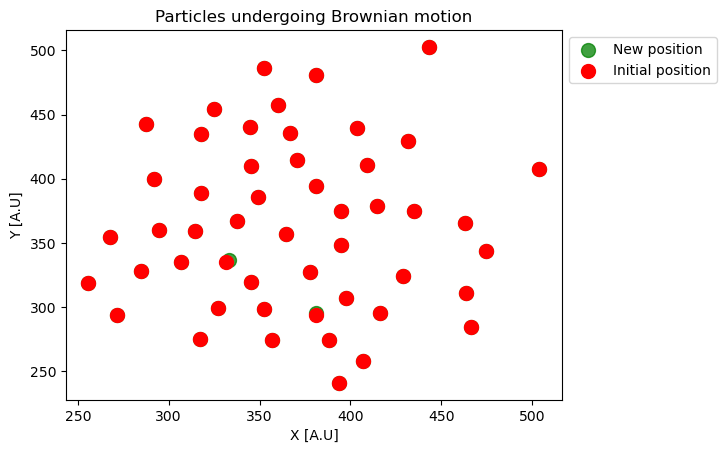

In [16]:
#to see difference

plt.scatter(new_pos[:,0], new_pos[:,1], color = 'green', alpha = 0.75, s = 100,
           label = 'New position')
plt.scatter(particle_loc[:,0], particle_loc[:,1], color = 'red', s = 100, 
           label = 'Initial position')
plt.xlabel('X [A.U]')
plt.ylabel('Y [A.U]')
plt.title('Particles undergoing Brownian motion')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig('pics/Brown_motion.png', dpi=300, bbox_inches='tight')

Create frames

In [17]:
#new_pos - old_pos

In [18]:
def frame_generator_brown(particle_loc, n_frames):
    n = 0
    il = np.copy(particle_loc)
    nl = []
    while n < n_frames: #n X 25 new particle locations
        new_l, old_l = brown_motion(il, step_size, diff, bounds, p_amount)
        nn = np.vstack(new_l)
        nl.append(nn)
        il = nn
        n += 1
    
    frames = []
    for i in range(len(nl)):
        fr = sample(nl[i], radius)
        frames.append(fr)
    return frames

Define temperature change

In [19]:
#p1 = np.linspace(20, 30, int(n_frames/3))
#p2 = np.linspace(30, 30, int(n_frames/3))
#p3 = np.linspace(31, 40, int(n_frames/3))

In [20]:
#tt = np.hstack((p1,p2,p3))
#len(tt)

In [21]:
#tt[0]

In [22]:
def frame_generator_brown_temp(particle_loc, n_frames, temp):
    n = 0
    il = np.copy(particle_loc) #copy initial locations
    nl = [] #new locations
    temps = np.linspace(temp[0], temp[1], n_frames) #temp increase
    #temps = tt
    rad = np.linspace(radius + (int(temps[0]) / 10), radius + (int(temps[-1]) / 10), n_frames) #radius increase
    
    while n < n_frames: # N amount of new locations
        new_l, old_l = brown_motion_temp(il, step_size, diff, # Brown motion with temp/radius increase
                                         bounds, p_amount, temps[n], rad[n])
        nn = np.vstack(new_l)
        nl.append(nn)
        il = nn #make new locations initial locations for next step
        n += 1
        
    
    frames = []
    for i in range(len(nl)):
        fr = sample(nl[i], rad[i])
        frames.append(fr)
    return frames, temps

In [23]:
%%time
frames_t, temps = frame_generator_brown_temp(particle_loc, n_frames, temp) # Amount of frames, 
                                                                        #temp_min, temp_max
frames = frame_generator_brown(particle_loc, n_frames)

CPU times: user 28.2 s, sys: 1.76 s, total: 29.9 s
Wall time: 30.2 s


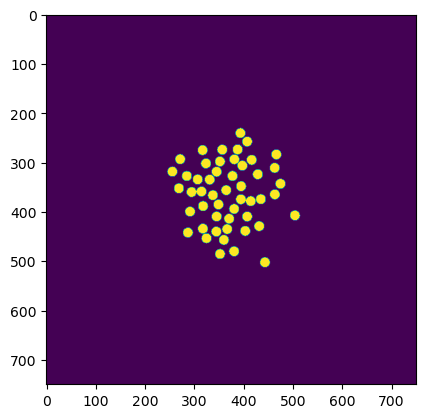

In [24]:
plt.imshow(frames[0])

Animation of moving particles

In [25]:
def animation(frames, temps, show = True):
    if show == True:
        num_frames = len(frames)
        fig, ax = plt.subplots()
        im = ax.imshow(frames[0], cmap='viridis')
        temp_text = ax.text(0.05, 0.95, '', transform = ax.transAxes, 
                              color = 'white', fontsize = 12, ha = 'left', va = 'top')
        #rad_text = ax.text(0.1, 0.95, '', transform = ax.transAxes,
        #                      color = 'white', fontsize = 12, ha = 'left', va = 'top')
        
        def update(frame):
            im.set_array(frames[frame]) 
            temp_text.set_text(f'Temperature: {np.round(temps[frame], 2)} K')
            #rad_text.set_text(f'Radius: {np.round(rad[frame], 2)} nm')
            return [im, temp_text]
    
        ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=True)
        return HTML(ani.to_jshtml())
    else:
        return plt.imshow(frames[0])

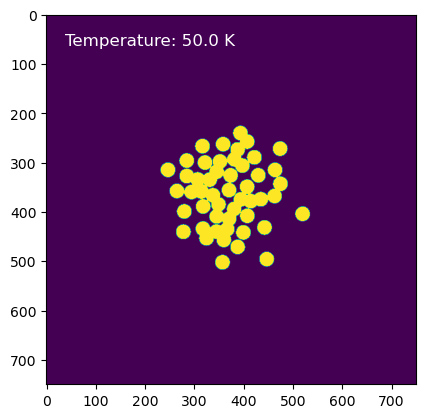

In [26]:
animation(frames_t, temps, show = True)

Simulate beam

In [27]:
#---------Defining image extents---------# 
pixelspace = dim/2                                                # in units of pixels
pixel_extent = [-pixelspace, pixelspace, -pixelspace, pixelspace]

sample_pixel_size = dim * 10e-9 #Dim in [nm] to [m]
realspace = (sample_pixel_size * (dim/2))                         # [currently m]
real_extent = [-realspace, realspace, -realspace, realspace]

recipspace = (2 * np.pi / realspace)                               # in units of 'a' [currently AA]
recip_extent = [-recipspace, recipspace, -recipspace, recipspace]

In [28]:
realspace

0.0028125

In [29]:
# Define sample parameters
pixel_size = 1 # Pixel size
sample_detector_distance = 8e6  # Sample-detector distance 
wavelength = 1 # Wavelength in aa

# Define scattering vector components (in reciprocal space)
ny, nx = init_sample.shape
qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
q = np.sqrt(qx ** 2 + qy ** 2)

# Calculate scattering intensity
sc_intens = np.abs(fft.fft2(init_sample)) ** 2
sc_intens_q = np.fft.fftshift(np.fft.fft2(init_sample))

# XFEL beam
beam_profile = np.exp(- (q ** 2) / (4 * (1 / wavelength) ** 2))

# Simulate beam-sample interaction
intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))

# Generate speckle pattern 
spek = np.abs(intens)**2
speq = np.abs(intens_q)**2

In [30]:
q_extent = [qx.min(), qx.max(), qy.min(), qy.max()]
arrq = np.linspace(0, qx.max(), n_frames)

In [31]:
q_extent

[-0.5, 0.49866666666666665, -0.5, 0.49866666666666665]

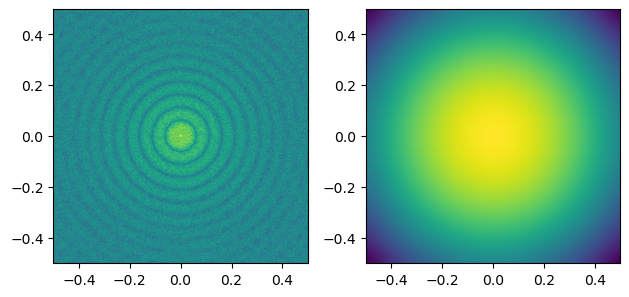

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log(speq), extent = q_extent)
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#ax1.colorbar()

ax2.imshow(spek, extent = q_extent)
plt.tight_layout()

Padding the matrix to get detector shape...

In [33]:
def zero_padding(matrix, target_shape):
    original_shape = matrix.shape
    padded_matrix = np.zeros(target_shape)
    
    # Center the original matrix in the padded matrix
    pad_top = (target_shape[0] - original_shape[0]) // 2
    pad_left = (target_shape[1] - original_shape[1]) // 2
    
    padded_matrix[pad_top:pad_top + original_shape[0], pad_left:pad_left + original_shape[1]] = matrix
    return padded_matrix

In [34]:
padded = []
for i in range(len(frames)):
    padded.append(zero_padding(frames[i], (4000,4000)))

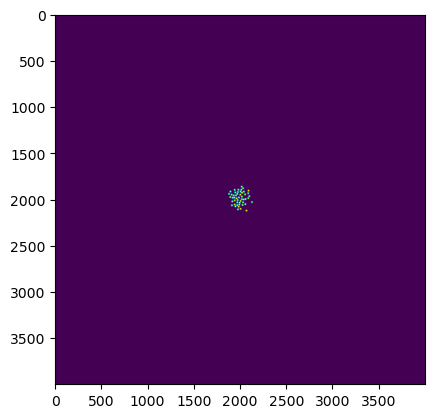

In [35]:
plt.imshow(padded[1])

In [36]:
#Function for creating scattered frames 

def speck_q(frames):
    spekls = []
    speqls = []
    for i in range(len(frames)):
        sp = frames[i] 

        ny, nx = sp.shape
        qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
        q = np.sqrt(qx**2 + qy**2)


        sc_intens = np.abs(fft.fft2(sp))**2
        sc_intens_q = np.fft.fftshift(np.fft.fft2(sp))


        beam_profile = np.exp(-(q**2) / (4 * (1 / wavelength)**2))


        intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
        intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))


        spek = np.abs(intens)**2
        speq = np.abs(intens_q)**2

        spekls.append(spek)
        speqls.append(speq)

    return spekls, speqls
        

In [37]:
%%time
speks, speqs = speck_q(frames)

CPU times: user 7 s, sys: 200 ms, total: 7.2 s
Wall time: 7.25 s


In [38]:
l_speks, l_speqs = speck_q(frames_t)

In [39]:
np.shape(speqs)

(100, 750, 750)

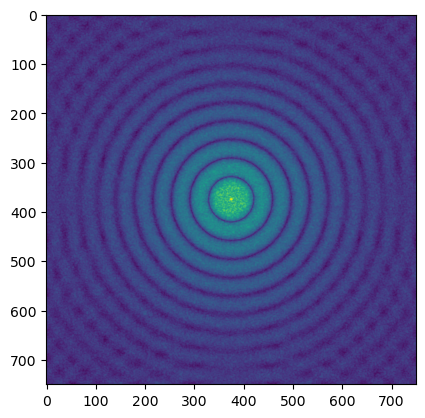

In [40]:
plt.imshow(np.log(np.mean(speqs, axis = 0)))

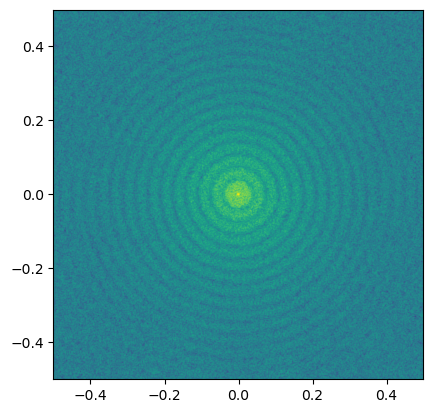

In [41]:
plt.imshow(np.log(l_speqs[-10]), extent = q_extent)
#plt.xlim(900,1100)
#plt.ylim(900,1100)

## Analysis - Azim integration

In [42]:
#Azimuthal integration
import math as m
image = (speqs[0])

center = (dim/2, dim/2)
d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))

centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
rad = np.sqrt((centered[0] ** 2) + (centered[1] ** 2))

r = np.linspace(1, int(center[0]) + 1, int(center[0]))

d = lambda r : image[(rad >= r - 0.5) & (rad < r + 0.5)].mean()


In [43]:
def azimuthal_int(image):
    im = image
    center = (dim/2, dim/2)
    d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))
    
    centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
    rad = np.sqrt((centered[0] ** 2 + (centered[1] ** 2)))
                  
    r = np.linspace(1, int(center[0]) + 1, int(center[0]))
                  
    d = lambda r : im [(rad >= r - 0.5) & (rad < r + 0.5)].mean()
                  
    mean_d = np.vectorize(d)(r)
    
    return mean_d

In [44]:
azz = azimuthal_int(speqs[0])
from scipy.signal import find_peaks

peaks, _ = find_peaks(azz, distance = 20)
peaks
p_x = np.linspace(0,len(azz),len(peaks))

In [45]:
peaks

array([  4,  26,  64, 100, 136, 179, 213, 248, 289, 326, 362])

In [46]:
pp = np.linspace(0, int(dim/2), int(dim/2))

In [47]:
rois = []
for i in range(1, len(peaks)):
    l_roi = pp[peaks[i]] - 5
    u_roi = pp[peaks[i]] + 5
    rois.append([int(l_roi), int(u_roi)])

In [48]:
rois

[[21, 31],
 [59, 69],
 [95, 105],
 [131, 141],
 [174, 184],
 [208, 218],
 [243, 253],
 [284, 294],
 [321, 331],
 [357, 367]]

In [49]:
q_azim = np.linspace(0, qx.max(), len(azimuthal_int(speqs[0])))

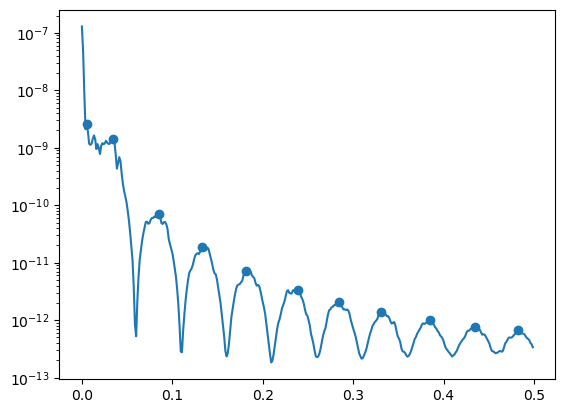

In [50]:
plt.plot(q_azim, azimuthal_int(speqs[0]))
plt.scatter(q_azim[peaks], azz[peaks])
plt.yscale('log')

In [51]:
center

(375.0, 375.0)

In [52]:
mean_d = np.vectorize(d)(r)

In [53]:
def sinc_func(x, amplitude, frequency, phase, offset):
    return amplitude  * np.sinc(frequency * (x - phase)) + offset

def chi2_sinc(amplitude, frequency, phase, offset):
    model = sinc_func(q_azim, amplitude, frequency, phase, offset)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

def osc_dec(x, A, lambda_, omega, phi):
    return A * np.exp(-lambda_ * x) * np.cos(omega * x + phi)

def chi2_od(A, lambda_, omega, phi):
    model = osc_dec(q_azim, A, lambda_, omega, phi)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

azim_fit = Minuit(chi2_sinc, amplitude = max(mean_d), frequency = 50, phase = 10, offset = min(mean_d))
azim_fit.migrad()

#fit_od = Minuit(chi2_od, A = 1, lambda_ = 1, omega = 1, phi = 1)
#fit_od.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 371.5                      │              Nfcn = 222              │
│ EDM = 6.68e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ amplitude │  1.5e-6   │  0.8e-6   │            │            │         │         │       │
│ 1 │ frequency │   51.3    │    0.9    │            │            │         │         │       │
│ 2 │ phase     │   9.75    │   0.17    │            │            │         │         │       │
│ 3 │ offset    │  0.6e-9   │  0.4e-9   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────────┐
│           │       amplitude       frequency           phase          offset │
├───────────┼─────────────────────────────────────────────────────────────────┤
│ amplitude │        6.32e-13       9.0056e-9      -1.7301e-9        4.02e-18 │
│ frequency │       9.0056e-9           0.826          -0.157 -5.90037271e-12 │
│     phase │      -1.7301e-9          -0.157          0.0297  1.10598922e-12 │
│    offset │        4.02e-18 -5.90037271e-12  1.10598922e-12        1.34e-19 │
└───────────┴─────────────────────────────────────────────────────────────────┘

In [55]:
amp, freq, phase, off = azim_fit.values
y_azim = sinc_func(q_azim, amp, freq, phase, off)


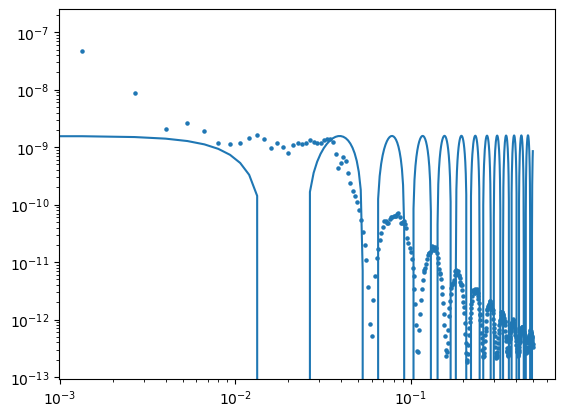

In [56]:
plt.scatter(q_azim, (mean_d), s = 5)
plt.plot(q_azim, (y_azim))
plt.yscale('log')
#plt.plot(q_azim, y_od)

plt.xscale('log')
#plt.ylim(-0.11e-7, 0.2e-7)

In [57]:
import pandas as pd

#sax = np.mean(d_sax[3], axis = 0)

d = {'q': q_azim, 'I(q)': np.array(mean_d)}

sasdf = pd.DataFrame(data = d)
sasdf.to_csv('samples/2dsim_mean.dat', index = False)

## ROIs

In [58]:
#Creating a ROI



x, y = np.ogrid[:dim, :dim]
c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
mask = (c_dist <= roi_params[1]) & (c_dist >= roi_params[0])

c_roi = np.zeros_like(speqs[0])
c_roi[mask] = speqs[0][mask]

In [59]:
#Function to calculate get rois

def roi(upper, lower, speqs):
    roi = [upper, lower]
    
    x, y = np.ogrid[:dim, :dim]
    c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    mask = (c_dist <= roi[1]) & (c_dist >= roi[0])
    
    rois = []

    for i in range(len(speqs)):
        mat = np.zeros_like(speqs[i])
        mat[mask] = speqs[i][mask]
        rois.append(mat[mask])
        
    return np.array(rois)

In [60]:
rois[0]

[21, 31]

In [61]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))
    

In [62]:
len(rr)

10

In [63]:
rr[0]

array([[3.81620706e-10, 1.25892300e-10, 6.31159739e-11, ...,
        6.31162451e-11, 1.25891555e-10, 3.81620855e-10],
       [2.94302082e-10, 1.89880442e-10, 1.27708225e-10, ...,
        1.27709651e-10, 1.89880124e-10, 2.94302328e-10],
       [2.56205657e-10, 1.95996254e-10, 7.81958228e-11, ...,
        7.81954824e-11, 1.95994966e-10, 2.56205748e-10],
       ...,
       [6.85697001e-11, 5.54383856e-11, 2.59236359e-10, ...,
        2.59236428e-10, 5.54380330e-11, 6.85693627e-11],
       [1.10562695e-10, 2.75015513e-11, 2.36847909e-10, ...,
        2.36847862e-10, 2.75011507e-11, 1.10561759e-10],
       [1.39480593e-10, 1.99569868e-11, 2.10192138e-10, ...,
        2.10191780e-10, 1.99568244e-11, 1.39480297e-10]])

In [64]:
ones = np.ones(np.shape(speqs))
same = ones * speqs[0]

## TTCF

In [65]:
w = roi(roi_params[0], roi_params[1], (speqs))
w_t = roi(roi_params[0], roi_params[1], l_speqs)
w_s = roi(roi_params[0], roi_params[1], same)

In [66]:
w.shape

(100, 11348)

In [67]:
np.shape(speqs)

(100, 750, 750)

In [68]:
ttcf = np.matmul(w, w.T)
ttcf_t = np.matmul(w_t, w_t.T)
ttcf_s = np.matmul(w_s, w_s.T)

Text(0, 0.5, '$T_{2}$ [A.U]')

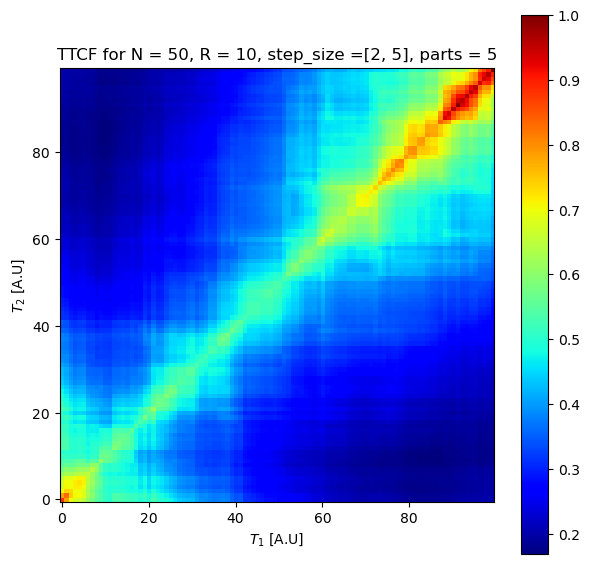

In [69]:
plt.figure(1, figsize = (7,7))
plt.imshow(ttcf_t/ttcf_t.max(), cmap = 'jet', origin = 'lower')
plt.colorbar()
plt.title('TTCF for N = {}, R = {}, step_size ={}, parts = {}'.format(N,radius, 
                                                                      step_size, p_amount))
#print(np.mean(ttcf))
plt.xlabel(r'$T_{1}$ [A.U]')
plt.ylabel(r'$T_{2}$ [A.U]')
#plt.savefig('pics/ttcf_1000_frames_wTitle.png', dpi = 300)

In [70]:
from matplotlib import colormaps
#list(colormaps)

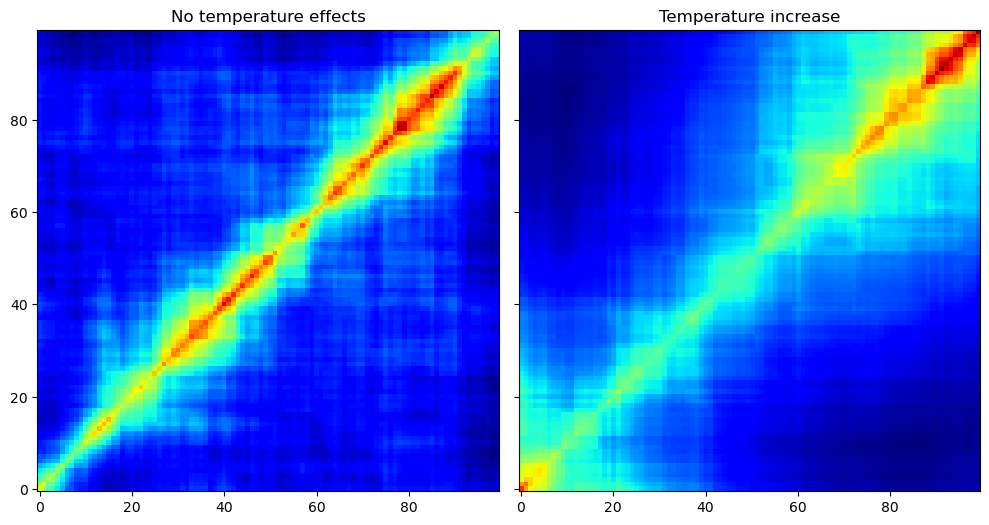

In [71]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,10))

im1 = ax1.imshow(ttcf / ttcf.max(), origin = 'lower', cmap = 'jet')
ax1.set_title('No temperature effects')


im2 = ax2.imshow(ttcf_t / ttcf_t.max(), origin = 'lower', cmap = 'jet')
ax2.set_title('Temperature increase')
plt.tight_layout()

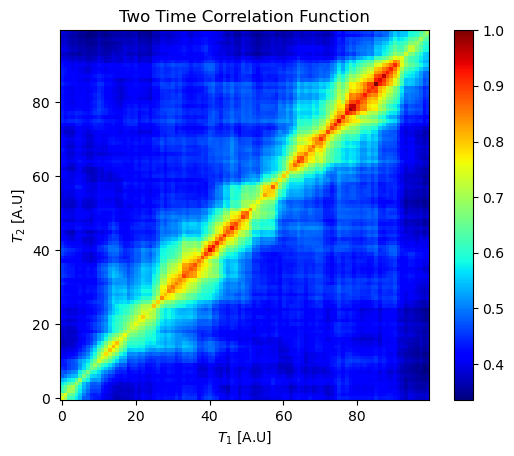

In [72]:
plt.figure()
plt.imshow(ttcf / ttcf.max(), origin = 'lower', cmap = 'jet')
plt.colorbar()
plt.xlabel(r'$T_{1}$ [A.U]')
plt.ylabel(r'$T_{2}$ [A.U]')
plt.title('Two Time Correlation Function')
plt.savefig('pics/TTCF_2d.png', dpi = 300)

In [73]:
ttcf_t.max()

6.293128441153093e-18

In [74]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def e_decay(dt,Gm,beta,off):
    g1 = np.exp(-Gm*dt)
    g2 = beta*g1**2+off
    return g2

g2 = get_cf(ttcf/ttcf.max())
g2_t = get_cf(ttcf_t / ttcf_t.max())
t_steps = np.linspace(0, len(g2_t), len(g2_t))

y_err = np.std(g2) 

In [75]:
def chi2(Gm,beta,off):
    y_exp = e_decay(t_steps,Gm,beta,off)
    chi2 = np.sum(((g2 - y_exp) / np.std(g2))**2)
    return chi2

def chi2_t(Gm, beta, off):
    y_exp = e_decay(t_steps, Gm, beta, off)
    chi2 = np.sum(((g2_t - y_exp) / np.std(g2_t))**2)
    return chi2

In [76]:
g2_t[0]

0.6420894844400074

In [77]:
fit = Minuit(chi2, beta = g2[0], Gm = 5, off = min(g2))
fit.migrad()
fit_t = Minuit(chi2_t, beta = g2_t[0], Gm = 5, off = min(g2_t))
fit_t.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9547                     │              Nfcn = 132              │
│ EDM = 1.55e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Gm   │   0.015   │   0.005   │            │            │         │         │       │
│ 1 │ beta │   0.45    │   0.05    │            │            │         │         │       │
│ 2 │ off  │   0.16    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────┐
│      │        Gm      beta       off │
├──────┼───────────────────────────────┤
│   Gm │  2.24e-05 -0.026e-3  0.180e-3 │
│ beta │ -0.026e-3   0.00211   -0.0009 │
│  off │  0.180e-3   -0.0009   0.00179 │
└──────┴───────────────────────────────┘

In [78]:
Gm, beta, off = fit.values
gm_unc, beta_unc, off_unc = fit.errors
Gm_t, beta_t, off_t = fit_t.values

fit_curve = e_decay(t_steps, Gm, beta, off)
cf_t = e_decay(t_steps, Gm_t, beta_t, off_t)

chi2_val = np.round(fit.fval,2)
chi2_val_t = np.round(fit_t.fval, 2) 

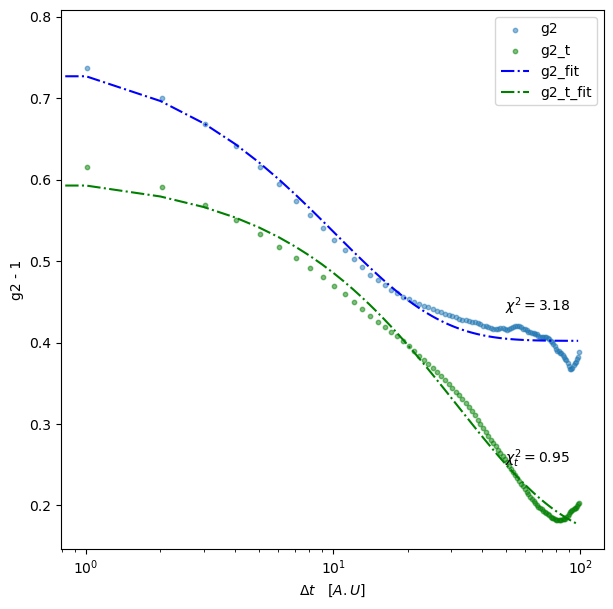

In [79]:
plt.figure(1, figsize = (7,7))

plt.scatter(t_steps, get_cf(ttcf/ttcf.max()), s = 10,
           label = 'g2', alpha = 0.5)

plt.scatter(t_steps, get_cf(ttcf_t / ttcf_t.max()), s = 10,
            color = 'green', label = 'g2_t', alpha = 0.5)
            
plt.plot(fit_curve, color = 'b', alpha = 1, label = 'g2_fit', ls = '-.')
plt.plot(cf_t, color = 'g', alpha = 1, label = 'g2_t_fit', ls = '-.')
plt.ylabel('g2 - 1')
plt.xlabel(r'$\Delta t \quad [A.U]$')
plt.text(x = len(g2) - len(g2)/2, y = g2[-1] + 0.05, s = r'$\chi^{} = {}$'.format(2,chi2_val));
plt.text(x = len(g2) - len(g2)/2, y = g2_t[-1] + 0.05, s = r'$\chi_t^{} = {}$'.format(2, chi2_val_t));
#plt.axvline(x = 50)
plt.xscale('log')
plt.legend()


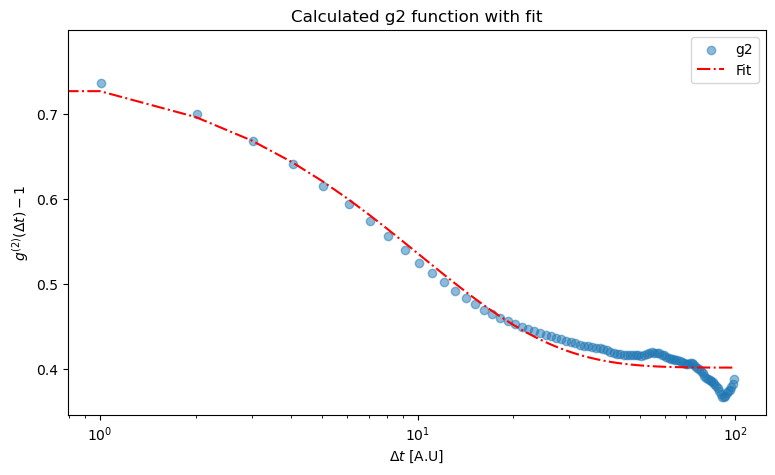

In [80]:
plt.figure(figsize = (9,5))
plt.scatter(t_steps, get_cf(ttcf / ttcf.max()), label = 'g2', alpha = 0.5)
plt.xscale('log')
plt.plot(fit_curve, c = 'red', ls = '-.', label = 'Fit', alpha = 1)
plt.legend()
plt.xlabel(r'$\Delta t$ [A.U]')
plt.ylabel(r'$g^{(2)}(\Delta t) - 1$');
plt.title('Calculated g2 function with fit');
plt.xscale('log')
#plt.text(x = len(g2) - len(g2)/2, y = g2[10], s = r'$\chi^{} = {}$'.format(2,chi2_val));
#plt.savefig('pics/g2_fit.png', dpi = 300)

In [81]:
y_err

0.07726937039067208

In [82]:
fit_params = ['Gm: Decay rate -- 1/Gm','beta: Contrast','off: Offset']
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4))


Gm: Decay rate -- 1/Gm 0.0486
beta: Contrast 0.3584
off: Offset 0.4021


In [83]:
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit_t.values[i],4))

Gm: Decay rate -- 1/Gm 0.0155
beta: Contrast 0.4511
off: Offset 0.1556


In [84]:
1/fit.values[0]

20.56857629893591

In [85]:
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4), 'pm' ,np.round(fit.errors[i],4))


Gm: Decay rate -- 1/Gm 0.0486 pm 0.0118
beta: Contrast 0.3584 pm 0.0461
off: Offset 0.4021 pm 0.0105


For step_size = [5,10] --- CAP


In [86]:
fit_params = ['Gm: Decay rate','beta: Contrast','off: Offset']
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4))


Gm: Decay rate 0.0486
beta: Contrast 0.3584
off: Offset 0.4021


In [87]:
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit_t.values[i],4))

Gm: Decay rate 0.0155
beta: Contrast 0.4511
off: Offset 0.1556


In [88]:
np.log(1/ (fit.values[1] ** 2))

2.0519970226094344

## Multiple ROIs

In [89]:
rois = []
q_vals = []
for i in range(1, len(peaks)):
    l_roi = pp[peaks[i]] - 5
    u_roi = pp[peaks[i]] + 5
    rois.append([int(l_roi), int(u_roi)])
    q_val = [q_azim[int(l_roi)], q_azim[int(u_roi)]]
    q_vals.append(q_val)

In [90]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))

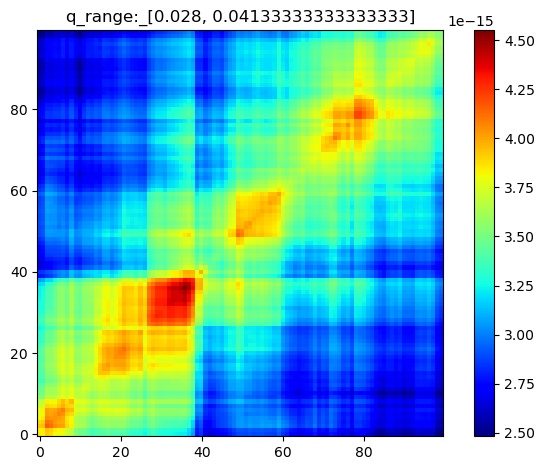

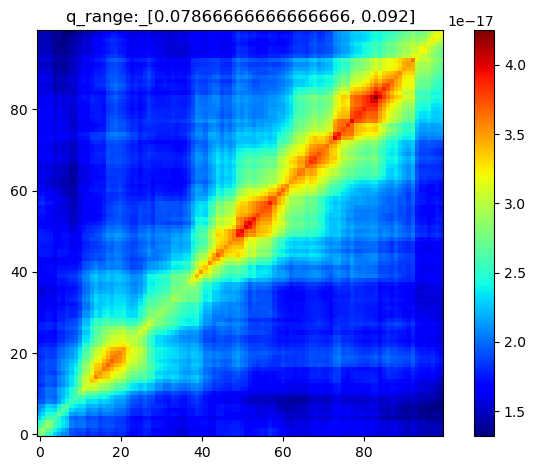

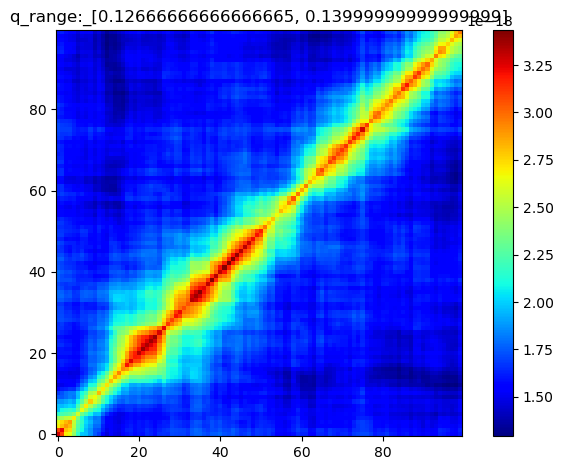

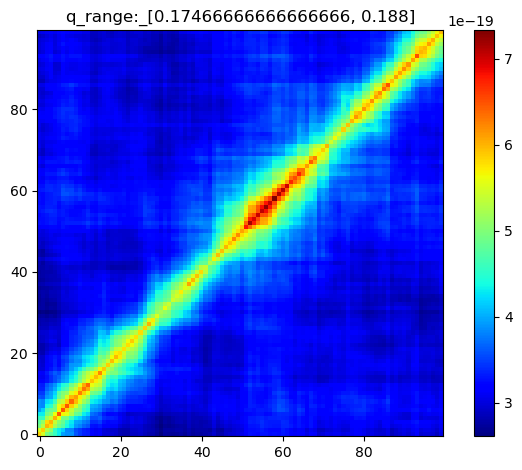

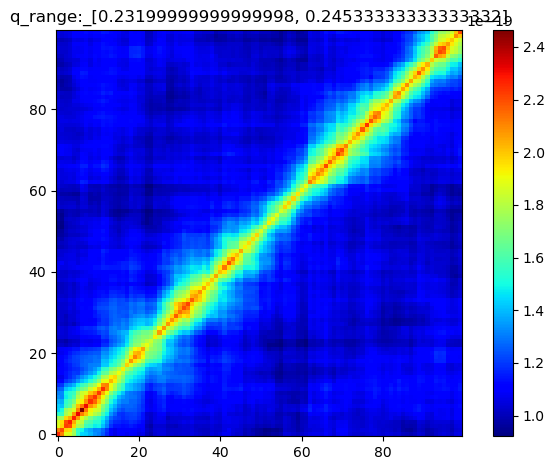

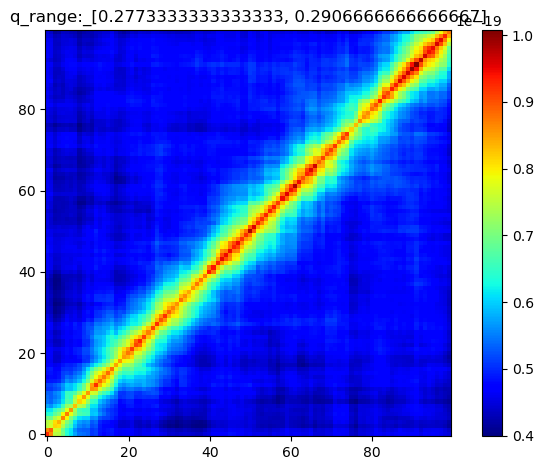

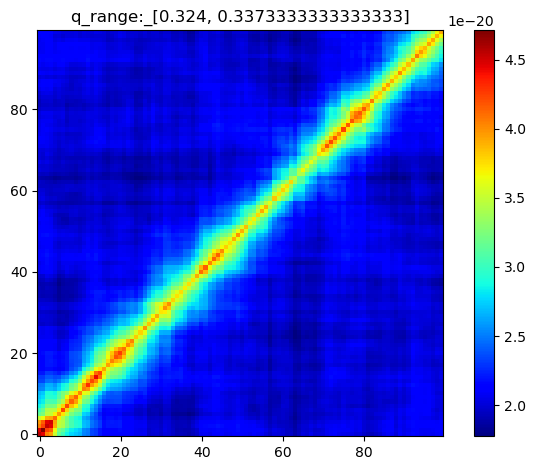

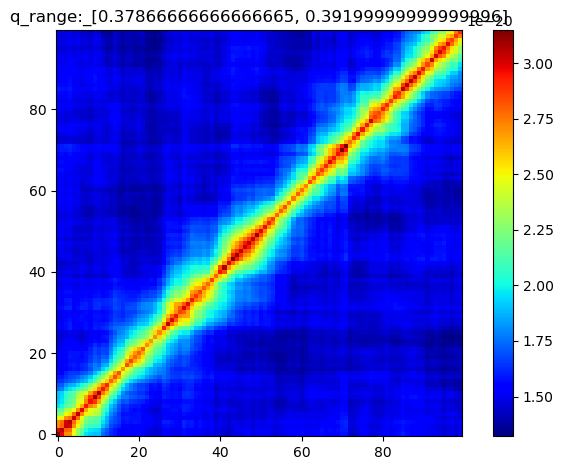

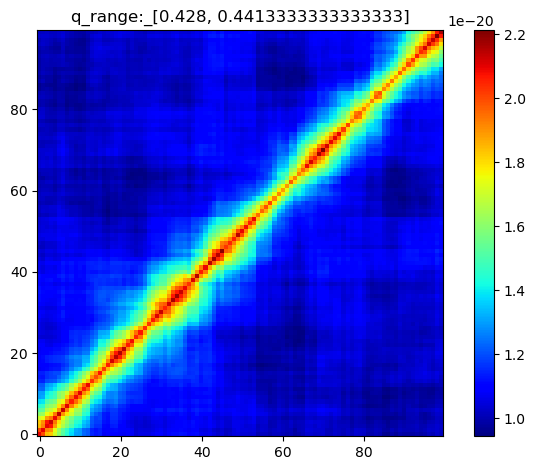

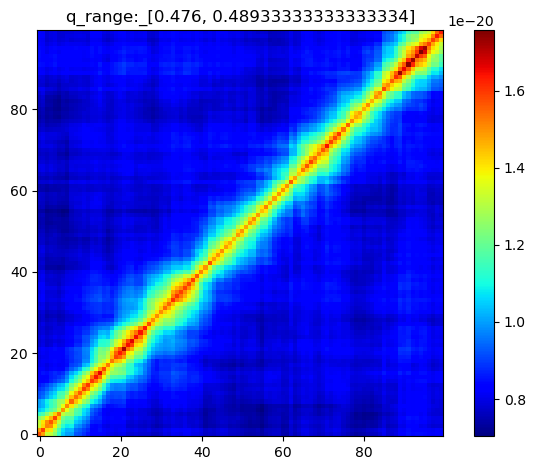

In [91]:
for i in range(len(rr)):
    plt.figure(i)
    plt.imshow(np.matmul(rr[i], rr[i].T), cmap = 'jet', origin = 'lower')
    plt.title('q_range:_{}'.format(q_vals[i]))
    plt.colorbar()
    plt.tight_layout()

In [92]:
g2s = []
for i in range(len(rr)):
    ttcf = np.matmul(rr[i], rr[i].T)
    g = get_cf(ttcf / ttcf.max())
    g2s.append(g)

In [93]:
np.shape(g2s)

(10, 99)

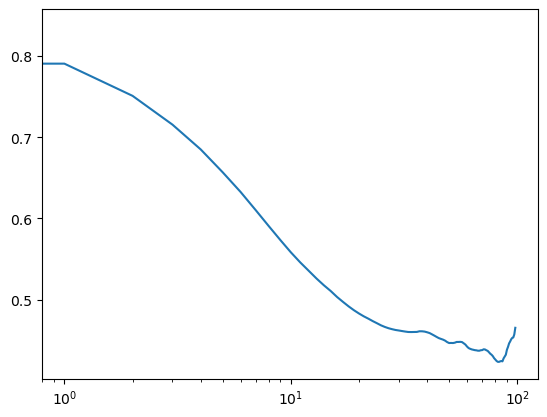

In [94]:
plt.plot(g2s[2])
plt.xscale('log')

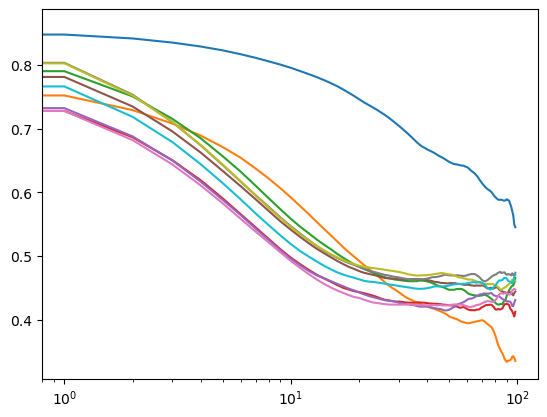

In [95]:
for i in range(len(g2s)):
    plt.plot(g2s[i])
    plt.xscale('log')